# Bank Marketing dataset

The data comes from <a href='https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#'>UCI Machine learning repository</a> of a retail bank in Portugal from their telemarketing campaign of term deposits products. 

Term deposits = long-term locked-in accounts with higher saving rates

The business objectives are as follows: 


1. Determine the characteristics that makes a client subscribe from a campaign from **statistical analysis** and **predictive modelling**. 
2. Build a predictive model to help sales team **reach the right clients** and deliver **better experience for clients**




# Data description
Here are the features available in the dataset: 
0. *y* :Whether client subscribe to a deposit term after campaign

**bank client data:**

1.   *age* (numeric)
2.   *job* : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3.   *marital* : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.   *education* (categorical: 'basic.4y', 'basic.6y' ,'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
5.   *default*: has credit in default? (categorical: 'no',' yes',' unknown')
6. *housing*: has housing loan? (categorical: 'no','yes','unknown')
7. *loan*: has personal loan? (categorical: 'no','yes','unknown')




**related with the last contact of the current campaign:**

8. *contact*: contact communication type (categorical: 'cellular','telephone') 
9. *month*: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. *day_of_week*: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. *duration*: last contact duration, in seconds (numeric). 
12. *campaign*: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. *pdays*: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. *previous*: number of contacts performed before this campaign and for this client (numeric)
15. *poutcome*: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')



**social and economic context attributes**

16. *emp.var.rate*: employment variation rate - quarterly indicator (numeric)
17. *cons.price.idx*: consumer price index - monthly indicator (numeric) 
18. *cons.conf.idx*: consumer confidence index - monthly indicator (numeric) 
19. *euribor3m*: Europe interbank borrowing rate avg 3 month  - daily indicator (numeric)
20. *nr.employed*: number of employees - quarterly indicator (numeric)

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [0]:
%%capture
!pip install numpy==1.15.4 pandas==0.23.4 matplotlib wget
!pip install seaborn==0.9.0 scipy==1.1.0 hyperopt
!pip install xgboost==0.81.0 scikit-learn==0.20.1 scikit-plot squarify
!pip install shap

import os
os.kill(os.getpid(), 9)

In [3]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
# import wget
# print('Downloading files....')
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
# wget.download(url) 
# print('Done!')
%matplotlib inline 
warnings.filterwarnings('ignore')

In [4]:
# import zipfile

# zf = zipfile.ZipFile('bank-additional.zip')
df = pd.read_csv('bank-additional-full.csv', 
                sep=';')

# First look at data

In [5]:
client_col = ['age', 'job', 'marital','education','default','housing',
             'loan', 'y']
clients = df[client_col]

context_var = ['emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

contexts = df[context_var]

campaign_col = ['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome','y']
campaigns = df[campaign_col]
campaigns['previous'] = campaigns['previous'].astype('category')


df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Client variables

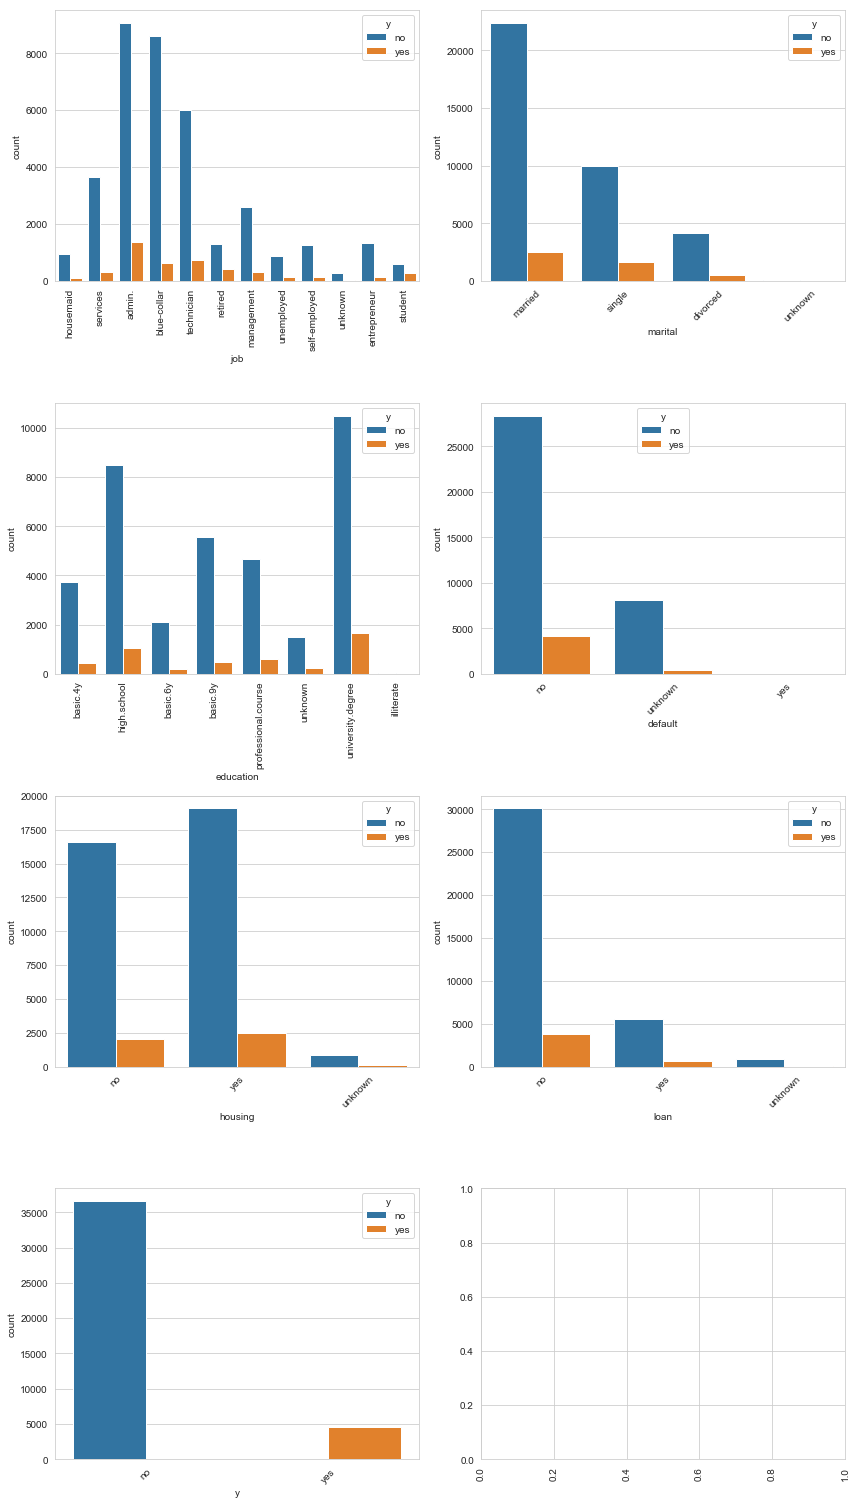

In [6]:
def cat_summary(df, cat_col,target, fw):
  sns.set_style('whitegrid')
  
  fh = np.ceil(fw/2*(len(cat_col)/2))
  
  
  fig,axes = plt.subplots(int(np.ceil(len(cat_col)/2)),2,figsize=(fw,fh))
  for idx,col in enumerate(cat_col):
      sns.countplot(data=df,x=col,hue=target,ax=fig.axes[idx])

  for ax in fig.axes:
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    
    if len(ax.get_xticklabels())>5:
      for tick in ax.get_xticklabels():
          tick.set_rotation(90)
    else:
      for tick in ax.get_xticklabels():
          tick.set_rotation(45)      
  plt.tight_layout()
  plt.show()

cat_col = [col for col in clients.columns if clients[col].dtype.name =='object']
cat_summary(clients, cat_col, 'y',12)

In [7]:
print('Defaults')
print(clients.default.value_counts())
print('-'*50)
print('Education')
print(clients.education.value_counts())
print('-'*50)
print('Marital status')
print(clients.marital.value_counts())

Defaults
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
--------------------------------------------------
Education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
--------------------------------------------------
Marital status
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


## Only weak relationship between clients categories and the outcome

In [16]:
#@title
from scipy.stats import chi2_contingency  

def cramer_v_cal(f,n,r,c):
  return np.sqrt((f/n)/np.min([r-1,c-1]))


def multi_chi2_tests(df, cat_col, target,alpha):
  
  cramer_v = []
  test_statistics = []
  p_values = []
  for col in cat_col:
    ct = pd.crosstab(df[col], df[target])
    res = chi2_contingency(ct)
    
    n = ct.sum().sum()
    r = ct.shape[0]
    c = ct.shape[1]
    cramer_val = cramer_v_cal(res[0],n,r,c)
    
    cramer_v.append(cramer_val)
    test_statistics.append(res[0])
    p_values.append(res[1])
   
  results = pd.DataFrame({'Variables':cat_col,
                        'Chi2 statistics':test_statistics,
                          'Cramer V': cramer_v,
                         'p-values': p_values})
  results['Sig.@ alpha='+str(alpha)] = ['yes' if p<=alpha else 'no' for p in p_values]
  
  if target in results.Variables.tolist():
    results.drop(results[results['Variables']==target].index,axis=0,inplace=True)
  
  return results

cat_col = [col for col in clients.columns if clients[col].dtype.name =='object' and col != 'y']
results = multi_chi2_tests(clients, cat_col, 'y', 0.05)

print('Pearson chi-squared test for categorical variables against whether client subscribe after telemarketing campaign')
results

Pearson chi-squared test for categorical variables against whether client subscribe after telemarketing campaign


,Chi2 statistics,Cramer V,Variables,p-values,Sig.@ alpha=0.05
0,961.242440,0.152768,job,4.189763e-199,yes
1,122.655152,0.054570,marital,2.068015e-26,yes
2,193.105905,0.068472,education,3.305189e-38,yes
3,406.577515,0.099354,default,5.161958e-89,yes
4,5.684496,0.011748,housing,5.829448e-02,no
5,1.094028,0.005154,loan,5.786753e-01,no


EDA Clients age
t-test for difference of mean between groups of outcome
t-statistic: 6.17, p-value: 0.000000


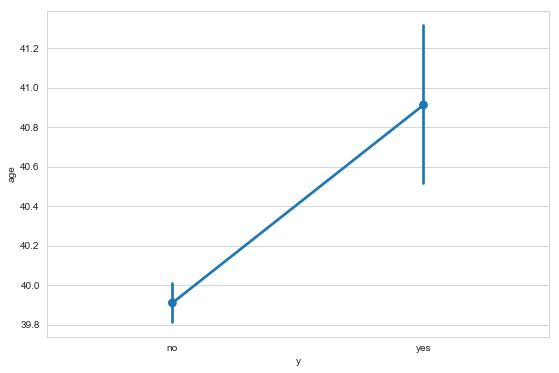

In [17]:
#@title

from scipy.stats import ttest_ind
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s


print('EDA Clients age')

t_stats, t_p_val = ttest_ind(clients.loc[clients['y']=='yes','age'].values,
                             clients.loc[clients['y']=='no','age'].values,
                             equal_var = True)
t_stats = np.round(t_stats,2)

t_p_val = format(t_p_val, '.6f')

print('t-test for difference of mean between groups of outcome') 
print('t-statistic: {}, p-value: {}'.format(t_stats, t_p_val))
plt.figure(figsize=(9,6))
sns.set_style('whitegrid')
sns.pointplot(data=clients, x='y', y='age', ci=95)

plt.show()

## But again statistical significance sometimes is not practical significance 

The cohen effect size in terms of age difference between outcome is 0.096


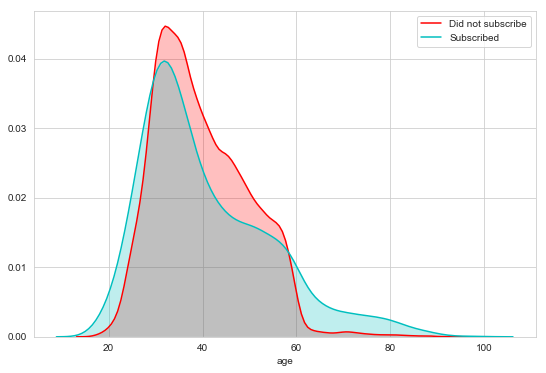

In [18]:
plt.figure(figsize=(9,6))
sns.distplot(clients.loc[clients['y']=='no','age'],hist=False,
             kde_kws={'shade':True},
            color='r', label='Did not subscribe',)
sns.distplot(clients.loc[clients['y']=='yes','age'],hist=False,
             kde_kws={'shade':True},
            color='c',label='Subscribed',)

plt.legend()

age_cohen = cohend(clients.loc[clients['y']=='yes', 'age'].values, 
                   clients.loc[clients['y']=='no', 'age'].values)
age_cohen = np.round(age_cohen,3)
print('The cohen effect size in terms of age difference between outcome is {}'.format(age_cohen))
plt.show()

## Summary for clients variables 



1.   With the current client data, we cannot distinguish between those who subscribe and those who does with high confidence
2.   We might need to obtain more variables: whether client is affluent, clients' income, maturity of their mortgage, client's risk/credit score, their spending patterns (aggregated transactions)



# Campaign variables

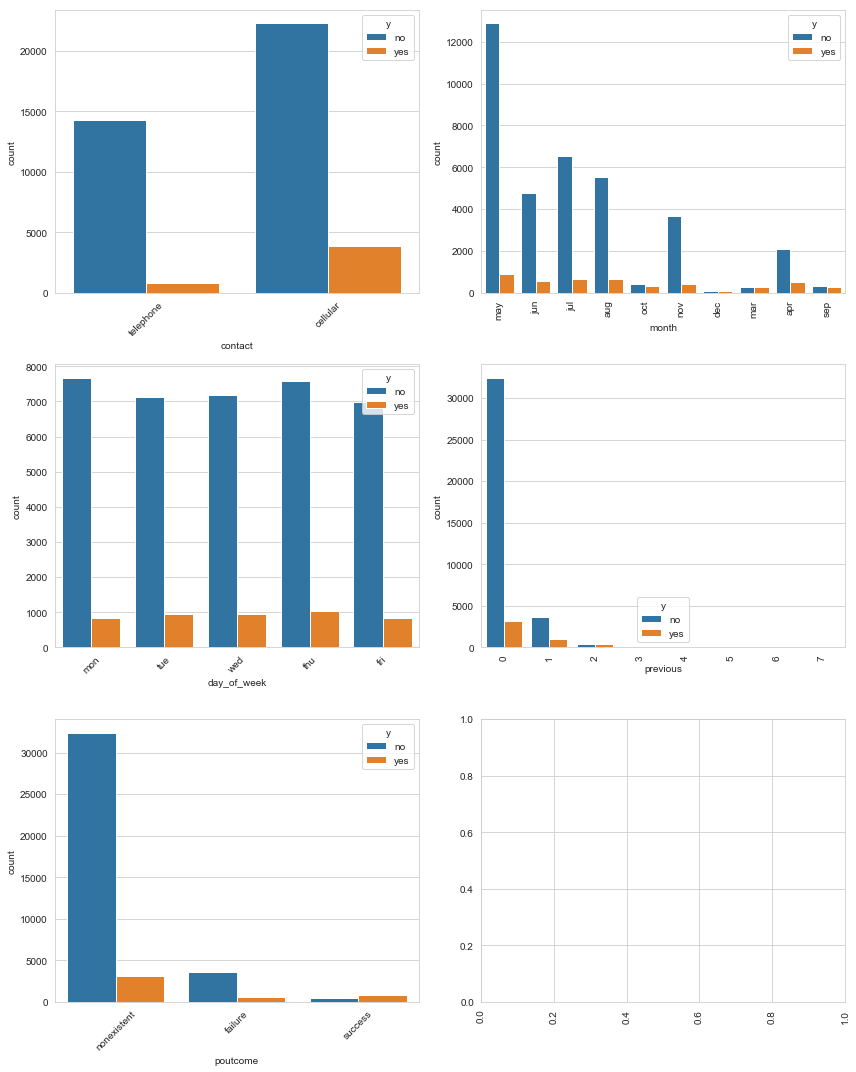

In [29]:
num_campaign =  ['duration', 'campaign', 'pdays']
cat_campaign = [col for col in campaigns.columns if col != 'y' and col not in num_campaign]
cat_summary(campaigns, cat_campaign, 'y',12)

## Again no campaign variables is meaningfully correlated with the outcome

In [30]:
results_2 = multi_chi2_tests(campaigns, cat_campaign, 'y', 0.05)

print('Pearson chi-squared test for categorical variables against whether client subscribe after telemarketing campaign')
results_2

Pearson chi-squared test for categorical variables against whether client subscribe after telemarketing campaign


,Chi2 statistics,Cramer V,Variables,p-values,Sig.@ alpha=0.05
0,862.318364,0.144693,contact,1.525986e-189,yes
1,3101.149351,0.274395,month,0.000000e+00,yes
2,26.144939,0.025195,day_of_week,2.958482e-05,yes
3,2299.436360,0.236279,previous,0.000000e+00,yes
4,4230.523798,0.320488,poutcome,0.000000e+00,yes


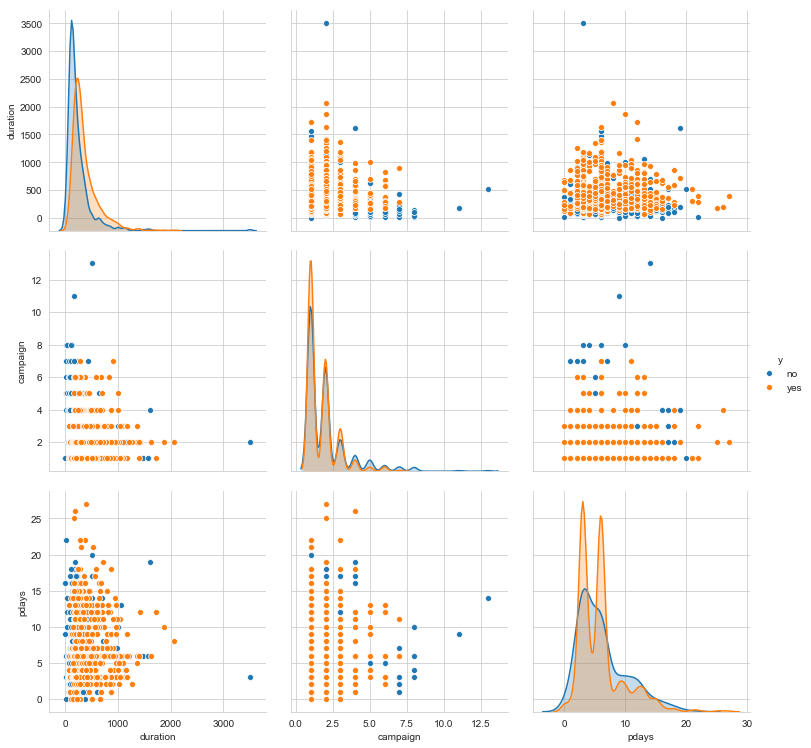

In [32]:
# plt.figure(figsize=(20,20))
# numcol=[col for col in campaigns.columns if col not in cat_campaign]
num_campaign.append('y')
sns.pairplot(campaigns.loc[campaigns['pdays']!=999,num_campaign], diag_kind ='kde', 
             height=3.5, hue='y')
plt.show()

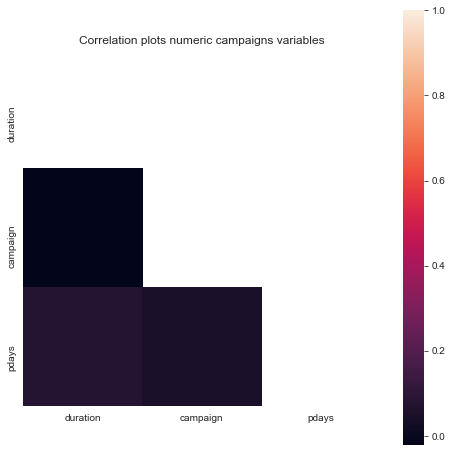

In [33]:
corr = campaigns.loc[campaigns['pdays']!=999,num_campaign].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask,square=True)
plt.title('Correlation plots numeric campaigns variables')
plt.show()



*   Expectedly call duration is heavily correlated with the outcome with effect size as large as 1.4 standard deviations. 
*   Including this in the predictive model would make no sense so we will remove it later. 



In [35]:
from scipy.stats import f_oneway


def multi_anova_oneway(df, num_col, target, alpha=0.05):
  
  groups = df[target].unique()
  f_val = []
  p_val = []
  cohen = []
  for col in num_col:
    group1 = df.loc[df[target]==groups[0], col].values
    group2 = df.loc[df[target]==groups[1],col].values
    f,p = f_oneway(group1, group2)
    d = cohend(group1, group2)
    cohen.append(d)
    f_val.append(f)
    p_val.append(p)
  
  results = pd.DataFrame({
      'Variables':num_col,
      'Cohen d': cohen,
      'F-statistics':f_val,
      'p-values':p_val,
      
  })
  results['Sig.@ '+str(alpha)] = ['no' if pv>alpha else 'yes' for pv in p_val]
  return results

print('ANOVA one-way tests')
results = multi_anova_oneway(campaigns, ['duration','campaign','pdays'],'y')
results

ANOVA one-way tests


,Cohen d,F-statistics,Variables,p-values,Sig.@ 0.05
0,-1.402100,8094.101634,duration,0.000000e+00,yes
1,0.210338,182.156673,campaign,2.007780e-41,yes
2,1.086588,4861.173272,pdays,0.000000e+00,yes


# Context variables

In [36]:
contexts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


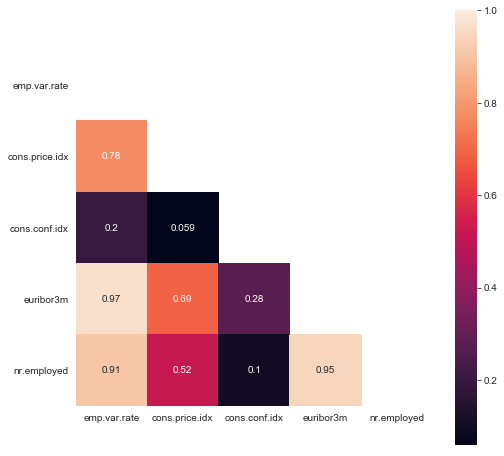

In [37]:
corr = contexts.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.yticks(rotation=0)
plt.show()

Looks like we have heavy multi-collinearity between economic variables, which is normal but wouldn't do well for traditional regression analysis

## Correlation between social and economic contexts and outcome



In [114]:
results_cont = multi_anova_oneway(contexts, ['emp.var.rate','cons.price.idx','cons.conf.idx',
                                            'euribor3m','nr.employed'], 'y')
results_cont

,Variables,Cohen d,F-statistics,p-values,Sig.@ 0.05
0,emp.var.rate,0.988586,4023.829925,0.000000e+00,yes
1,cons.price.idx,0.434859,778.589786,9.318965e-170,yes
2,cons.conf.idx,-0.173829,124.409975,7.536665e-29,yes
3,euribor3m,1.023074,4309.479048,0.000000e+00,yes
4,nr.employed,1.199769,5926.610646,0.000000e+00,yes


Europe interbank borrowing rate, number of citizens employed, and employment variation rate seems to have big impact on whether client has subscribed. 

Our hypotheses are: 


*   High interest rate makes it hard to offer much higher long-term rate so people shift away from long term deposits 
*   More people employed means the economy is doing well, other investments become more atractive than deposits

# Modelling

We will use decision trees to build a predictive model and analyse the most important predictor because: 


*   Some economic variables correlated with each other which violates the **multicollinearity** assumptions of regression
* We've seen the **weakly correlated nature** between independent variables and dependent variable which would violate the linear/logistic relationship required by regression. 
*   We have **high class imbalance** (less subscribed than not) which regression is not equipped to deal with.
* A lot of decision trees model are **scalable** with larger datasets. 
* Decision trees offer automated feature selection due to its nature compared to manual** feature selection** in regression analysis

The chosen package is Extreme Gradient Boosting (xgboost)





## Data processing

**Input**:


*   Client variables (6 categorical, 1 numeric)
*   Campaign variables ( 5 categorical, 3 numeric)
* Social/Economic context variables (5 numeric)

**Output**

* Predicted probability (from 0 to 1) that a client is going to subscribe to a term deposit

**Processing**

* Scaling numeric variables
* One-hot encoding of categorical independent variables
* Label encoding of target variable: 1 - yes, 0 - no


In [0]:
target=['y']
exclude = ['duration', 'y']
predictors = [col for col in df.columns if col not in exclude]
dtypes_col = ['object','category']
cat_col = [col for col in df.columns if df[col].dtype.name in dtypes_col and col != 'y']
num_col = [col for col in df.columns if col not in cat_col and col not in exclude]

X = df[predictors]
X = pd.get_dummies(X)

y = df[target]

In [123]:
print('The shape of predictors is {}'.format(X.shape))
print('The shape of target is {}'.format(y.shape))

The shape of predictors is (41188, 62)
The shape of target is (41188, 1)


In [0]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from collections import defaultdict

scaler = RobustScaler()
encoder = LabelEncoder()
y = y.apply(encoder.fit_transform)

X[num_col] = scaler.fit_transform(X[num_col])

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X, y = shuffle(X,y,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [126]:
%%time
hyperopt = {'colsample_bytree': 0.55, 'eta': 0.005, 'max_depth': 4, 
            'min_child_weight': 5.0, 'subsample': 1.0}

d_train = xgb.DMatrix(data=X_train, label=y_train, nthread=-1)
d_test = xgb.DMatrix(data=X_test, label=y_test,nthread=-1)

watch_list = {(d_test, 'eval'), (d_train, 'train')}


param_set = {'objective':'binary:logistic',
             'eval_metric':'auc',
             'seed':42,
             'tree_method':'gpu_hist', 
             'growpolicy':'lossguide',
             'scale_pos_weight':float(np.sum(y.y==0)/np.sum(y.y==1))}

param_set.update(hyperopt)


rounds = 2000
eval_loss = {}

xgbclf = xgb.train(params=param_set, dtrain=d_train,maximize=True,
                        evals=watch_list, num_boost_round=rounds,
                       verbose_eval=200,#early_stopping_rounds = int(rounds/10),
                       callbacks=[xgb.callback.record_evaluation(eval_loss)])

[0]	eval-auc:0.77659	train-auc:0.79086
[200]	eval-auc:0.787509	train-auc:0.801548
[400]	eval-auc:0.789473	train-auc:0.805303
[600]	eval-auc:0.792038	train-auc:0.809257
[800]	eval-auc:0.792666	train-auc:0.812517
[1000]	eval-auc:0.793453	train-auc:0.816033
[1200]	eval-auc:0.793637	train-auc:0.818966
[1400]	eval-auc:0.794603	train-auc:0.82192
[1600]	eval-auc:0.795376	train-auc:0.825111
[1800]	eval-auc:0.796124	train-auc:0.827617
[1999]	eval-auc:0.796708	train-auc:0.83012
CPU times: user 30.9 s, sys: 6.34 s, total: 37.2 s
Wall time: 26.8 s


In [0]:
y_pred = xgbclf.predict(d_test, ntree_limit=xgbclf.best_iteration)

In [0]:
#@title
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score, confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_cumulative_gain


def class_bin_eval(y_test, y_pred, threshold=0.5):
  sns.set_style("whitegrid")
  
  
  fig = plt.figure(figsize=(14,7))
  gridsize=(1,2)
  
  actual_prediction = np.where(y_pred>threshold, 1,0)
  
  class0 = 1-y_pred
  y_proba = pd.DataFrame({'0':class0, '1':y_pred})
  
  #Confusion matrix
  
  ax1 = plt.subplot2grid(gridsize, (0, 0))
  confusion = confusion_matrix(y_test, actual_prediction)
  sns.heatmap(confusion, annot=True, 
              cmap="YlGnBu",
             ax=ax1)
  
  ax1.set_title('Confusion matrix')
  ax1.set_xlabel('Predicted')
  ax1.set_ylabel('Truth')
  
  #Bar plots other metrics
  
  ax2 = plt.subplot2grid(gridsize, (0, 1))
  
  precision = precision_score(y_test, actual_prediction)
  recall = recall_score(y_test, actual_prediction)
  accuracy = accuracy_score(y_test, actual_prediction)
  f1 = f1_score(y_test, actual_prediction)
  
  scores = pd.DataFrame(data=[[accuracy , precision, recall, f1]],
                       columns=['Accuracy', 'Precision', 'Recall', 'F1_score'])
  
  sns.barplot(data=scores, orient='h', ax=ax2).set_title('Metrics')
  
  for idx, col in enumerate(ax2.patches):
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(col.get_width()+0.02, col.get_y()+0.45, 
            np.round(scores.iloc[:,idx][0],5), fontsize=12,
    color='black')
  
  
  
  plt.tight_layout()
  plt.show(block=False)
  


## Evaluation

* Accuracy is misleading in unbalanced case like this
* Our model understands that False Positive is better than False Negative
* The model can be greatly improved if more data about clients/campaign was available. Including 'duration' improved Recall to 90%

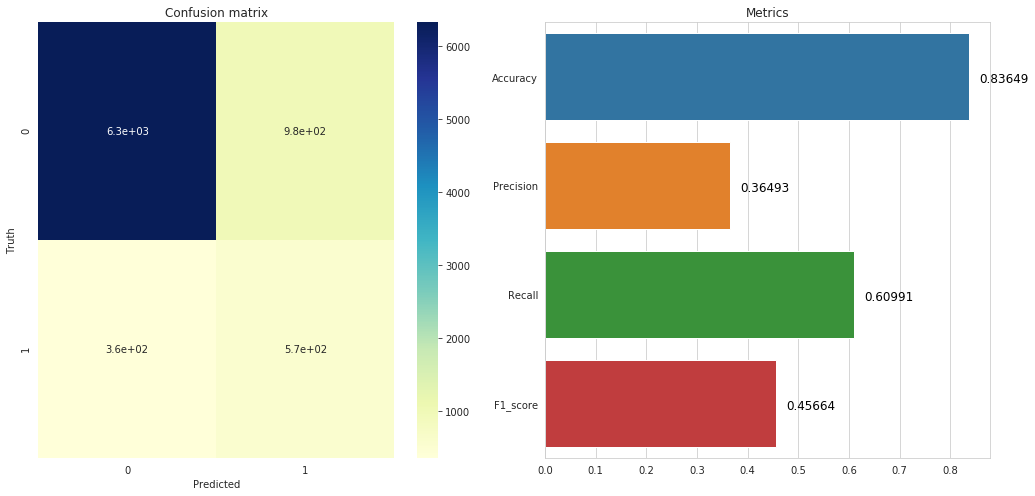

In [129]:
class_bin_eval(y_test, y_pred, 0.5)

## Which variable is the most important?

Top 4 (all economic variables): 

1.   Number of citizens emloyed average 3 month
2.   Europe interbank borrowing rates average 3 month
3. Emloyment variation rate 
4. Consumer confidence index 



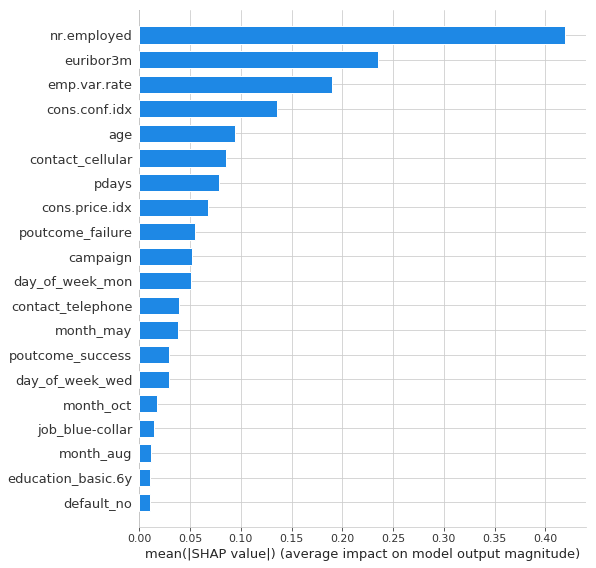

In [133]:
import shap

explainer = shap.TreeExplainer(xgbclf)
shap_val = explainer.shap_values(X, approximate=True)

shap.summary_plot(shap_val, X, plot_type='bar')


## How predictors affect the outcome?



* The top 4 variables **(economic contexts)** are negatively correlated with the predicted outcome. The better the economy, the less likely clients are to subscribe. 
* **Contact method**: People are more likely to subscribe if they were contacted on cellphone. 

*Caveats*: could be sampling bias where clients using cellphone are richer thus more likely to have long term deposits.
* **Past outcome**: If the past outcome is failure, there is little chance of client subscribing & vice versa. 

*Caveats*: clients previously subscribed have a higher prior probability of subscribing. 
* **Number of contacts**: The more times a client is contacted the less likely they are to subscribe. 

*Caveats*: clients not willing to subscribe in the first place intentionally prolong the contact to multiple times OR complicated procedures make clients change their mind. 
* **Last contact**: The fewer days since last contact, the more likely client are to subscribe. 
* **Day of contact**: Clients are less likely to accept if contacted on Monday



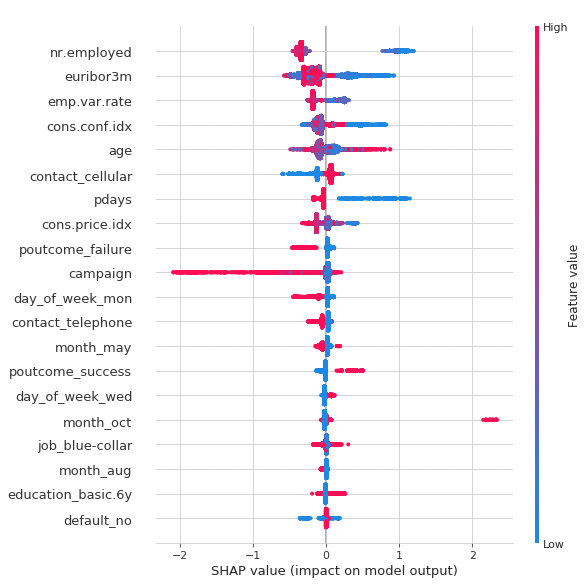

In [131]:
shap.summary_plot(shap_val, X)

## How do we improve this model?

Adding variables: 

*   **Phone call contexts**: Caller profile(number of sales this month number of years experience); inbound/outbound call;  time of day; 

*   **Client variables**: Income, banking relationship (whether they have other types of account with us), spending pattern (in context of income), 

* **Product variables**: national monthly average term deposit rate, most client-suited rate according to banks (best-offered), best-offered minus national average, type of product offered



## What can we do with this model?

Several possible applications given a predicted probability of subscription: 


*   Sort clients by probability of acceptance and call the most likely first. If a value per each acceptance is given (i.e. profit if subscribe) we can optimise the call list to call only the top 20% valuable and likely to accept clients first. 

*   Given clients probability of acceptance of each product, optimise the offerings to all clients. Matrix of decision: n-products x m-clients

* Optimise allocation of caller to clients to improve success rate.  

